# Classification. Linear models and KNN

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [140]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from seaborn import heatmap

In [142]:
PATH = "./data/"

In [143]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [144]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [145]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [146]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [148]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [150]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

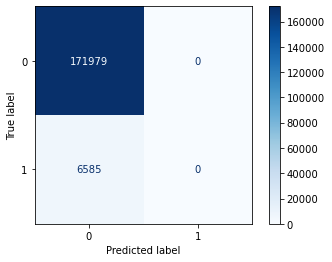

In [151]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [152]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

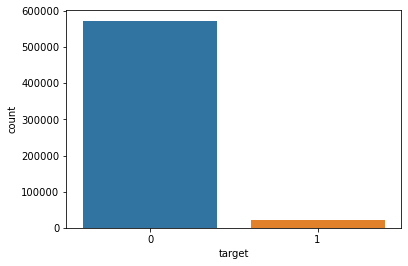

In [153]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [154]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Let's try to prove that the Normalized Gini Coefficient is equivalent to 2 x AUC - 1. For better understanding, let's do it, for instance, on a topic of  diseased subjects and non-diseased subjects.

AUC is defined as the probability that the predicted probability of a randomly selected diseased subject will exceed that of a randomly selected non-diseased subject. AUC is a value between 0.5 and 1.0, with a higher value indicating better prediction performance. 

Assume that there are a total of  subjects (indexed ) in a population, of which  () subjects are diseased (), and  () subjects are non-diseased (). Assume a prediction model which yields a predicted probability, , for each and every subject in the population. The prediction model is well calibrated and unbiased such that the mean predicted probability, , is equal to disease prevalence in the population, that is,  Fig. 1 presents the computing formulas and interpretations of various performance measures AUC and Gini.

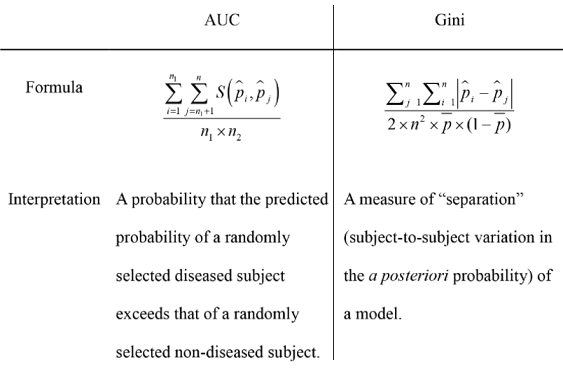

For AUC -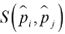is a scoring function comparing the predicted probabilities for a pair of subjects:  

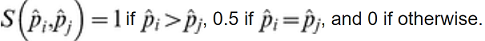

The formula clearly shows that AUC is the probability that the predicted probability of a randomly selected diseased subject exceeds that of a randomly selected non-diseased subject.

Let's compare the computing formulas for Gini:

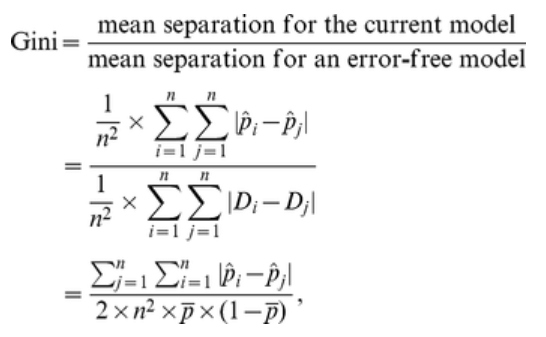

We can see, that Gini quantifies the “separation” (subject-to-subject variation in the a posteriori probability) of a model.

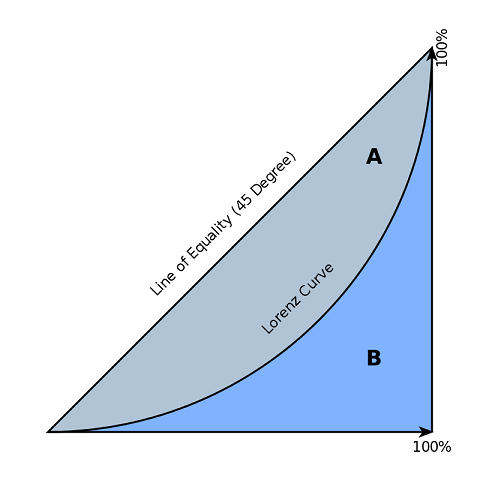

The Gini index is a measure of statistical heterogeneity and are derived from Lorenz curve and the diagonal line.
Gini coefficient is defined as twice the area between the receiver operating characteristic (ROC) curve and its diagonal. It is related to the AUC (Area Under the ROC Curve) measure of performance given by AUC=(G+1)/2.

The graph shows that the Gini coefficient is equal to the area marked A divided by the sum of the areas marked A and B, that is, Gini = A/(A + B). It is also equal to 2A and to 1 − 2B due to the fact that A + B = 0.5 (since the axes scale (NORMALIZED) from 0 to 1).

The AUC measure of performance is closely related to the Gini coefficient, which is sometimes used as an alternative measure. This is most commonly defined as twice the area between the ROC curve and the diagonal. 
Elementary geometry shows that Normalized Gini + 1 = 2 × AUC,

and Normalized Gini = 2 x AUC - 1. 

So, we have proved that **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1**


**(0.5 points)** By the way, what other metrics could you suggest for this problem?

- Accuracy - доля правильных ответов алгоритма:

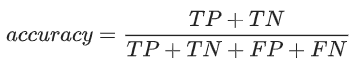

- Precision - можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными

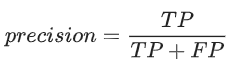

- Recall - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм

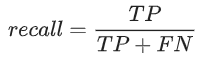

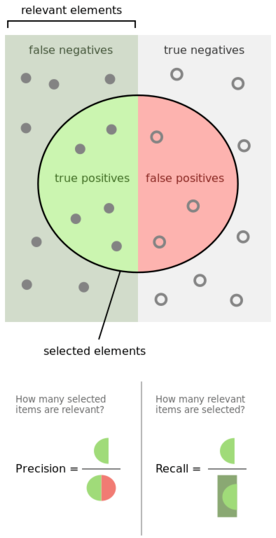

 - F-мера -  среднее гармоническое precision и recall :
 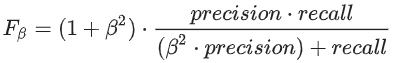

В sklearn есть удобная функция _metrics.classificationreport, возвращающая recall, precision и F-меру для каждого из классов, а также количество экземпляров каждого класса.

- AUC-ROC (ROC-AUC) - площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

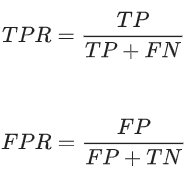

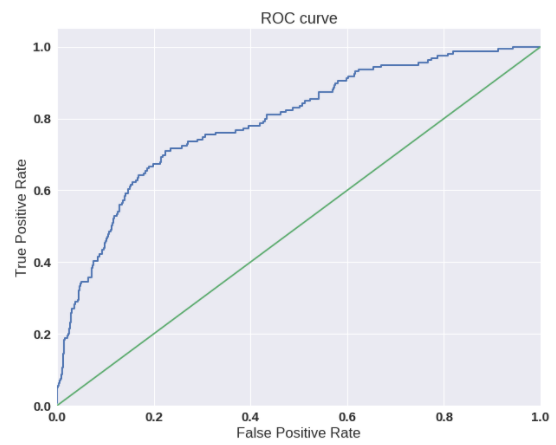

Критерий AUC-ROC более устойчив к несбалансированным классам и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект.

Logistic Loss - 
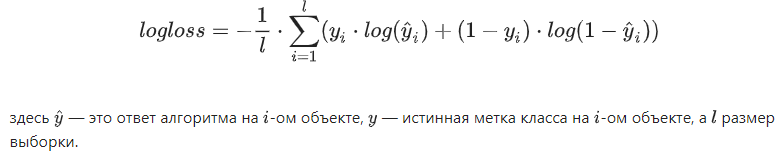

Интуитивно можно представить минимизацию logloss как задачу максимизации accuracy путем штрафа за неверные предсказания. Однако, logloss крайне сильно штрафует за уверенность классификатора в неверном ответе.

Let's calculate the Normalized Gini Coefficient:

In [155]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [156]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [157]:
insurance_data['type'] = 'train'
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')
insurance_data_test['type'] = 'test'

data = pd.concat([insurance_data, insurance_data_test])

In [158]:
data

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,type
id,,,,,,,,,,,,,,,,,,,,,
7,0.0,2,2,5,1,0,0,1,0,0,...,1,5,8,0,1,1,0,0,1,train
9,0.0,1,1,7,0,0,0,0,1,0,...,1,1,9,0,1,1,0,1,0,train
13,0.0,5,4,9,1,0,0,0,1,0,...,2,7,7,0,1,1,0,1,0,train
16,0.0,0,1,2,0,0,1,0,0,0,...,2,4,9,0,0,0,0,0,0,train
17,0.0,0,2,0,1,0,1,0,0,0,...,1,1,3,0,0,0,1,1,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488022,NaN,0,1,6,0,0,0,1,0,0,...,2,3,4,0,1,0,0,1,0,test
1488023,NaN,5,3,5,1,0,0,0,1,0,...,2,2,11,0,0,1,1,0,0,test
1488024,NaN,0,1,5,0,0,1,0,0,0,...,2,2,11,0,1,1,0,0,0,test


In [159]:
y = data['target']
X = data.drop(columns=['target'])

In [176]:
numerical_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numerical_features.remove('type')
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features),
                  ('cat', categorical_transformer, categorical_features)])
       
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000
                                        , class_weight='balanced'
                                        , n_jobs=-1))])  

Мы попробовали - **LogisticRegression** со сбалансироваными данными - **class_weight='balanced'** и распараллелили вычисления по ядрам процессора - **n_jobs=-1** для ускорения процесса вычислений

In [177]:
y_train = data[data['type'] == 'train']['target']

In [178]:
X_train, X_test = X[data['type'] == 'train'], X[data['type'] == 'test']

**** LogisticRegression *****

In [179]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                              

In [180]:
y_train_preds = pipeline.predict(X_train)

In [181]:
print('Normalized gini coefficient is %.2f' % gini_normalized(y_train, y_train_preds))

Normalized gini coefficient is 0.19


In [172]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76    573518
         1.0       0.05      0.55      0.10     21694

    accuracy                           0.63    595212
   macro avg       0.51      0.59      0.43    595212
weighted avg       0.94      0.63      0.74    595212



Комбинированная метрика **classification_report** показала низкую **precision**= 0.05, но довольно хорошую **recall**=0.55

In [173]:
test_preds = pipeline.predict(X_test)

In [174]:
X_test['target'] = test_preds.astype(int)

<ipython-input-174-215e22e62c6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['target'] = test_preds.astype(int)


In [175]:
X_test['target'].to_csv('data/porto/predictions.csv', index_label='id')

Не смотря на все усилия, **Normalized gini coefficient is 0.19** и **Kaggle Score = 0,18871**

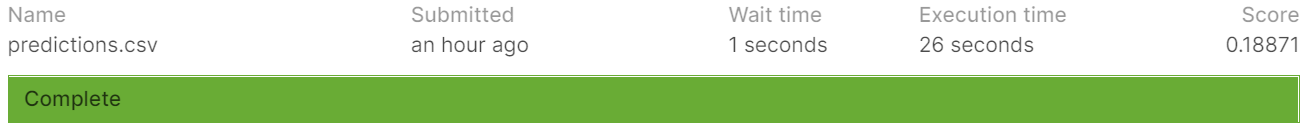

Попробуем метод №2            ***** SGDClassifier *****

In [182]:
numerical_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numerical_features.remove('type')
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log',
                                                        alpha=0.001,
                                                        class_weight='balanced',
                                                        n_jobs=-1, random_state=14))])

Мы попробовали - **SGDClassifier** со сбалансироваными данными - **class_weight='balanced'** и распараллелили вычисления по ядрам процессора - **n_jobs=-1** для ускорения процесса вычислений

In [183]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                              

In [184]:
y_train_preds = pipeline.predict(X_train)

In [185]:
print('Normalized gini coefficient is %.2f' % gini_normalized(y_train, y_train_preds))

Normalized gini coefficient is 0.18


In [186]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    573518
         1.0       0.06      0.47      0.10     21694

    accuracy                           0.70    595212
   macro avg       0.52      0.59      0.46    595212
weighted avg       0.94      0.70      0.80    595212



In [187]:
test_preds = pipeline.predict(X_test)

In [188]:
X_test['target'] = test_preds.astype(int)

<ipython-input-188-215e22e62c6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['target'] = test_preds.astype(int)


In [189]:
X_test['target'].to_csv('data/porto/predictions.csv', index_label='id')

Не смотря на все усилия, **Normalized gini coefficient is 0.18** и **Kaggle Score = 0,17445**
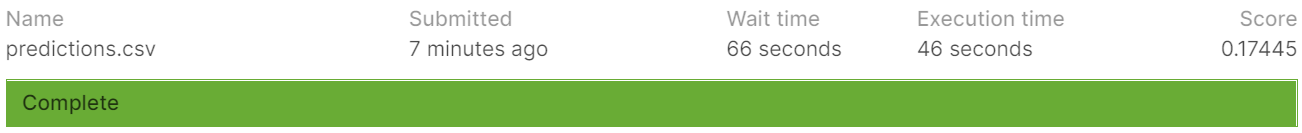